In [1]:
#!pip install scikit-learn

In [1]:
import cv2
import numpy as np
import os

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

from skimage.feature import greycomatrix, greycoprops
import mahotas as mt # Mahotas library for GLCM calculation
from skimage import feature # feature.local_binary_pattern for LBP calculation

import joblib as jb
# from sklearn.externals import joblib

from sklearn.svm import LinearSVC

In [4]:
train_path = './waste_images/train'  
training_names = os.listdir(train_path)

image_paths = [] # Get path to all images and save them in a list
image_classes = [] # Corresponding labels in image_paths
class_id = 0

# To make it easy to list all file names in a directory let us define a function
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

# Fill the placeholder empty lists with image path, classes, and add class ID number
 
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [5]:
image_paths[:10]

['./waste_images/train\\Aluminium\\Aluminium1.JPG',
 './waste_images/train\\Aluminium\\Aluminium18.JPG',
 './waste_images/train\\Aluminium\\Aluminium21.JPG',
 './waste_images/train\\Aluminium\\Aluminium26.JPG',
 './waste_images/train\\Aluminium\\Aluminium3.JPG',
 './waste_images/train\\Aluminium\\Aluminium30.JPG',
 './waste_images/train\\Aluminium\\Aluminium31.JPG',
 './waste_images/train\\Aluminium\\Aluminium32.JPG',
 './waste_images/train\\Aluminium\\Aluminium37.JPG',
 './waste_images/train\\Aluminium\\Aluminium40.JPG']

In [6]:
# total number of images in the training set
len(image_paths)

565

In [7]:
# classes
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

# BRISK - Feature Point Detector

Binary Robust Invariant Scalable Keypoints (BRISK) is a feature point detection and description algorithm with scale and rotation invariance. It constructs the feature descriptor of the local image through the gray scale relationship of random point pairs in the neighborhood of the local image, and obtains the binary feature descriptor. More detailed information at:

S. Leutenegger, M. Chli and R. Y. Siegwart, "BRISK: Binary Robust invariant scalable keypoints," 2011 _International Conference on Computer Vision_, 2011, pp. 2548-2555, doi: 10.1109/ICCV.2011.6126542.

In [8]:
# Create feature extraction and keypoint detector objects
# SIFT is not available anymore in openCV    

# Create list where all the descriptors will be stored
des_list = []

#BRISK is a good replacement to SIFT.
brisk = cv2.BRISK_create(30)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))

In [9]:
# initialize vector to stack
descriptors = des_list[0][1]
descriptors

array([[176, 255, 255, ...,   0, 224, 239],
       [252, 255, 255, ...,   0, 128, 205],
       [180, 123, 207, ...,  13,   0, 128],
       ...,
       [255, 159,  33, ...,   8,   0, 128],
       [176, 255, 223, ...,  60,   0,   0],
       [160, 251, 255, ...,  32, 243, 242]], dtype=uint8)

In [10]:
# Stack all the descriptors vertically into a numpy array
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

In [11]:
print(descriptors.shape)
descriptors

(824182, 64)


array([[176, 255, 255, ...,   0, 224, 239],
       [252, 255, 255, ...,   0, 128, 205],
       [180, 123, 207, ...,  13,   0, 128],
       ...,
       [251, 255, 239, ..., 136,  25,  48],
       [128, 255, 239, ..., 223, 153,  59],
       [240,  63, 199, ...,   8, 145,  50]], dtype=uint8)

In [12]:
# kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)

## Clustering

In order to analyse the best possible number of clusters to carry on with the analysis, we'll take a sample of the descriptors dataset and run the clustering algorithm with different values of __k__ and then use _Silhoutte Score_ to decide the best option.

In [13]:
np.random.seed(1658)
sample_idx = np.random.choice(descriptors_float.shape[0], size = int(descriptors_float.shape[0]*0.1), replace = False)
descriptors_sample = descriptors_float[sample_idx]
print(descriptors_sample.shape)

(82418, 64)


In [14]:
# import Silhouette Score implementation from scikit-learn
from sklearn.metrics import silhouette_score

In [15]:
# recommendation is to explore between 25 and 1.000 clusters
n_clusters = np.arange(25, 1000, 50)
scores=[]
for k in n_clusters:
    voc_sample, _ = kmeans(descriptors_sample, k, 1) 
    clusters, _ = vq(descriptors_sample, voc_sample)
    score = silhouette_score(descriptors_sample, clusters)
    scores.append(score)

In [16]:
import matplotlib.pyplot as plt

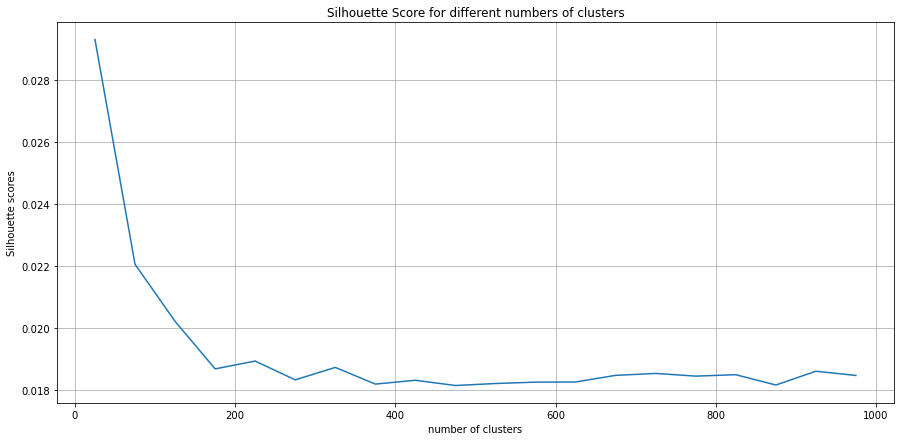

In [18]:
fig=plt.figure(figsize=(15,7))
plt.title("Silhouette Score for different numbers of clusters")
plt.plot(n_clusters, scores)
plt.ylabel("Silhouette scores")
plt.xlabel("number of clusters")
plt.grid()
plt.savefig('silhouette_scores.png')

The silhouette scores suggests that the clusters obtained do not provide good segmentation for the data. Either way, as we can see in the chart above, 25 clusters has the best result among the ones tested. So let's carry on with the analysis using k = 25 and clusterize the whole dataset.

In [17]:
k = 200  
voc, variance = kmeans(descriptors_float, k, 1) 

In [18]:
voc

array([[230.30615508, 216.34479083, 232.46176392, ..., 113.50626166,
        109.05622169,  99.07993605],
       [163.81306629,  92.87815928, 190.29422985, ...,  46.01549833,
         94.02646638, 108.00643777],
       [193.54892865, 218.63132317, 238.59642147, ...,  50.93616081,
         59.57123923,  84.5522421 ],
       ...,
       [206.86092308, 195.64123077, 227.98523077, ...,  47.13292308,
         59.32020513,  89.84553846],
       [113.94271357,  45.41105528,  73.82964824, ..., 138.10527638,
         99.04170854, 107.31934673],
       [126.25699034,  84.37417387, 197.98322318, ...,  69.93340112,
         78.88739197,  88.59456024]])

In [19]:
variance

584.8518772834215

In [20]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations

im_features = np.zeros((len(image_paths), k), "float32")

for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1


In [21]:
im_features

array([[ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 4.,  1.,  3., ...,  3.,  2.,  6.],
       [ 0.,  0.,  1., ...,  1.,  1.,  0.],
       ...,
       [ 5.,  0.,  7., ...,  7.,  1.,  9.],
       [ 5.,  0.,  8., ..., 20.,  3.,  3.],
       [ 0.,  1.,  3., ...,  3.,  5.,  1.]], dtype=float32)

In [22]:
# Perform Tf-Idf vectorization
#nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
#idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

In [23]:
#idf

In [24]:
# Scaling the words
# Standardize features by removing the mean and scaling to unit variance
# In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [25]:
im_features

array([[-0.5542829 , -0.42659485, -0.7984955 , ..., -0.7781814 ,
        -0.58311075, -0.72223747],
       [-0.25958103, -0.3691119 , -0.49952266, ..., -0.50755817,
        -0.4866371 , -0.11626157],
       [-0.65251684, -0.42659485, -0.6988379 , ..., -0.6879737 ,
        -0.58311075, -0.84343266],
       ...,
       [-0.16134708, -0.42659485, -0.1008923 , ..., -0.14672726,
        -0.58311075,  0.24732399],
       [-0.16134708, -0.42659485, -0.0012347 , ...,  1.0259732 ,
        -0.39016342, -0.4798471 ],
       [-0.65251684, -0.3691119 , -0.49952266, ..., -0.50755817,
        -0.1972161 , -0.72223747]], dtype=float32)

In [26]:
# Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
clf = LinearSVC(max_iter=10000)  #Default of 100 is not converging
clf.fit(im_features, np.array(image_classes))

#Train Random forest to compare how it does against SVM
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(n_estimators = 100, random_state=30)
#clf.fit(im_features, np.array(image_classes))

LinearSVC(max_iter=10000)

In [27]:
# Save the SVM
# Joblib dumps Python object into one file
jb.dump((clf, training_names, stdSlr, k, voc), "bovw_brisk.pkl", compress=3) 

['bovw_brisk.pkl']

# GLCM Haralick Features

In [6]:
# Create List where all the descriptors will be stored
des_list = []

In [7]:
def extract_glcm_features(image):
        
        # Calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)

        # Return the mean
        #ht_mean = textures.mean(axis=0)
        #return ht_mean
        
        return textures

In [8]:
im = cv2.imread('./waste_images/train\\Aluminium\\Aluminium1.JPG')
#im

In [9]:
extract_glcm_features(im)

array([[ 1.43874883e-03,  7.21694274e+01,  9.78804635e-01,
         1.70248133e+03,  3.71078665e-01,  3.20915837e+02,
         6.73775590e+03,  7.99154034e+00,  1.10220036e+01,
         5.79455124e-04,  3.47754502e+00, -4.24903817e-01,
         9.98691883e-01],
       [ 1.10374277e-03,  7.96972871e+01,  9.76603290e-01,
         1.70317294e+03,  3.18623452e-01,  3.20809783e+02,
         6.73299447e+03,  7.98531811e+00,  1.13282624e+01,
         4.82560369e-04,  3.69817928e+00, -3.81295916e-01,
         9.97591688e-01],
       [ 1.50913178e-03,  1.20304132e+01,  9.96465880e-01,
         1.70203806e+03,  4.56491664e-01,  3.20943031e+02,
         6.79612181e+03,  7.98560668e+00,  1.03308796e+01,
         8.45868062e-04,  2.63666557e+00, -5.23454805e-01,
         9.99670472e-01],
       [ 1.05101975e-03,  8.20602564e+01,  9.75909607e-01,
         1.70317387e+03,  3.09783006e-01,  3.20809810e+02,
         6.73063522e+03,  7.98378936e+00,  1.13578710e+01,
         4.71840718e-04,  3.71816399e

In [10]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_glcm_features(gray_img)
    des_list.append((image_path, des)) 

In [13]:
len(des_list)

565

In [15]:
des_list[0][1].shape

(4, 13)

In [16]:
descriptors = des_list[0][1]
descriptors

array([[ 1.78320759e-03,  1.13070227e+01,  9.96540274e-01,
         1.63409244e+03,  4.75679478e-01,  3.19741334e+02,
         6.52506274e+03,  7.89248241e+00,  1.01342390e+01,
         9.16463324e-04,  2.56745517e+00, -5.32775787e-01,
         9.99681803e-01],
       [ 1.34598670e-03,  7.82852088e+01,  9.76062143e-01,
         1.63517581e+03,  3.37424367e-01,  3.19610420e+02,
         6.46241803e+03,  7.89342241e+00,  1.11145076e+01,
         5.30418649e-04,  3.62929853e+00, -3.91262701e-01,
         9.97753463e-01],
       [ 1.75898786e-03,  7.11968098e+01,  9.78220608e-01,
         1.63449951e+03,  3.92101849e-01,  3.19714933e+02,
         6.46680125e+03,  7.90090805e+00,  1.08001789e+01,
         6.37986698e-04,  3.40135486e+00, -4.36580354e-01,
         9.98798738e-01],
       [ 1.27394101e-03,  8.06387721e+01,  9.75342485e-01,
         1.63517640e+03,  3.27667781e-01,  3.19610443e+02,
         6.46006681e+03,  7.89043300e+00,  1.11449266e+01,
         5.15992350e-04,  3.65242593e

In [17]:
# Stack all the descriptors vertically in a numpy array
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor)) 

In [18]:
descriptors.shape

(2260, 13)

In [19]:
#descriptors

In [20]:
# kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)  

descriptors_float

array([[ 1.78320759e-03,  1.13070227e+01,  9.96540274e-01, ...,
         2.56745517e+00, -5.32775787e-01,  9.99681803e-01],
       [ 1.34598670e-03,  7.82852088e+01,  9.76062143e-01, ...,
         3.62929853e+00, -3.91262701e-01,  9.97753463e-01],
       [ 1.75898786e-03,  7.11968098e+01,  9.78220608e-01, ...,
         3.40135486e+00, -4.36580354e-01,  9.98798738e-01],
       ...,
       [ 2.50216100e-03,  6.23199055e+01,  9.80066095e-01, ...,
         2.77042062e+00, -5.14099303e-01,  9.99596558e-01],
       [ 3.09251666e-03,  3.62217184e+01,  9.88423939e-01, ...,
         2.44478914e+00, -5.66680549e-01,  9.99805885e-01],
       [ 2.54814157e-03,  6.35981489e+01,  9.79657470e-01, ...,
         2.74138472e+00, -5.19656152e-01,  9.99626461e-01]])

In [21]:
k = 200
voc, variance = kmeans(descriptors_float, k, 1) 

In [22]:
voc

array([[ 1.52404333e-03,  5.31175170e+01,  9.85161259e-01, ...,
         3.06342753e+00, -4.66428082e-01,  9.98940030e-01],
       [ 2.06742868e-03,  2.97386343e+01,  9.82996804e-01, ...,
         2.90473142e+00, -4.62658344e-01,  9.98265198e-01],
       [ 2.41402363e-03,  8.24309537e+01,  9.89735948e-01, ...,
         3.28233103e+00, -3.99548437e-01,  9.96716812e-01],
       ...,
       [ 2.08939220e-03,  1.11503934e+02,  9.85125428e-01, ...,
         3.83439733e+00, -4.10976468e-01,  9.98719841e-01],
       [ 1.92315396e-03,  1.07962477e+02,  9.86078085e-01, ...,
         3.36141421e+00, -4.44599671e-01,  9.98642746e-01],
       [ 1.62699596e-03,  7.36795395e+01,  9.68948267e-01, ...,
         3.16971280e+00, -4.40807363e-01,  9.98547483e-01]])

In [23]:
variance

99.19599928848882

In [24]:
voc.shape

(200, 13)

In [25]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations

im_features = np.zeros((len(image_paths), k), "float32")

for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [27]:
np.unique(im_features)

array([0., 1., 2., 3., 4.], dtype=float32)

In [28]:
# Scaling the words
# Standardize features by removing the mean and scaling to unit variance
# In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [29]:
im_features

array([[-0.09963634, -0.08873292, -0.05108428, ..., -0.05653338,
        -0.09396733, -0.08195126],
       [-0.09963634, -0.08873292, -0.05108428, ..., -0.05653338,
        -0.09396733, -0.08195126],
       [-0.09963634, -0.08873292, -0.05108428, ..., -0.05653338,
        -0.09396733, -0.08195126],
       ...,
       [-0.09963634, -0.08873292, -0.05108428, ..., -0.05653338,
        -0.09396733, -0.08195126],
       [-0.09963634, -0.08873292, -0.05108428, ..., -0.05653338,
        -0.09396733, -0.08195126],
       [-0.09963634, -0.08873292, -0.05108428, ..., -0.05653338,
        -0.09396733, -0.08195126]], dtype=float32)

In [30]:
# Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
clf = LinearSVC(max_iter=10000)  #Default of 100 is not converging
clf.fit(im_features, np.array(image_classes))

#Train Random forest to compare how it does against SVM
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(n_estimators = 100, random_state=30)
#clf.fit(im_features, np.array(image_classes))

LinearSVC(max_iter=10000)

In [33]:
# Save the SVM
# Joblib dumps Python object into one file
jb.dump((clf, training_names, stdSlr, k, voc), "bovw_glcm.pkl", compress=3) 

['bovw_glcm.pkl']

# LBP - Local Binary Patterns

In [2]:
# Create list where all the descriptors will be stored
des_list = []

In [3]:
def extract_lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    
    # normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    '''
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    return hist
    '''
    
    return lbp

In [4]:
im = cv2.imread('./waste_images/train\\Aluminium\\Aluminium1.JPG')

In [5]:
extract_lbp_features(im)

array([[3., 3., 5., ..., 1., 1., 1.],
       [1., 9., 8., ..., 5., 5., 3.],
       [5., 9., 7., ..., 5., 7., 5.],
       ...,
       [2., 0., 4., ..., 4., 4., 1.],
       [2., 4., 5., ..., 8., 5., 2.],
       [2., 4., 5., ..., 9., 9., 2.]])

In [9]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    #gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_lbp_features(im)
    des_list.append((image_path, des)) 

In [13]:
len(des_list)

565

In [14]:
des_list[0][1].shape

(480, 640)

In [15]:
descriptors = des_list[0][1]
descriptors

array([[3., 3., 5., ..., 1., 1., 1.],
       [1., 9., 8., ..., 5., 5., 3.],
       [5., 9., 7., ..., 5., 7., 5.],
       ...,
       [2., 0., 4., ..., 4., 4., 1.],
       [2., 4., 5., ..., 8., 5., 2.],
       [2., 4., 5., ..., 9., 9., 2.]])

In [25]:
removal_list = []

for image_path, descriptor in des_list[1:]:
    if (descriptor.shape[1] != (640)):
        #print(image_path, descriptor.shape)
        removal_list.append(image_path)

In [26]:
removal_list

['./waste_images/train\\Cable and Wire\\Cable and Wire105.JPG',
 './waste_images/train\\Cable and Wire\\Cable and Wire85.JPG',
 './waste_images/train\\Cardboard and Paper\\Cardboard and Paper11.JPG',
 './waste_images/train\\Cardboard and Paper\\Cardboard and Paper3.JPG',
 './waste_images/train\\Connector\\Connector24.JPG',
 './waste_images/train\\Connector\\Connector31.JPG',
 './waste_images/train\\Copper\\Copper29.JPG',
 './waste_images/train\\Iron\\Iron17.JPG',
 './waste_images/train\\Printed Circuit Board\\Printed Circuit Board170.JPG',
 './waste_images/train\\Printed Circuit Board\\Printed Circuit Board201.JPG',
 './waste_images/train\\Printed Circuit Board\\Printed Circuit Board218.JPG',
 './waste_images/train\\Printed Circuit Board\\Printed Circuit Board78.JPG',
 './waste_images/train\\Printer Ribbon and Toner\\Printer Ribbon and Toner19.JPG',
 './waste_images/train\\Printer Ribbon and Toner\\Printer Ribbon and Toner37.JPG',
 './waste_images/train\\Printer Ribbon and Toner\\Print

In [49]:
#des_list[0][0]

In [43]:
# Stack all the descriptors vertically in a numpy array
for image_path, descriptor in des_list[1:]:
        if image_path not in removal_list:
            #print(image_path)
            descriptors = np.vstack((descriptors, descriptor)) 

In [47]:
descriptors.shape

(318720, 640)

In [50]:
# kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)  

descriptors_float

array([[3., 3., 5., ..., 1., 1., 1.],
       [1., 9., 8., ..., 5., 5., 3.],
       [5., 9., 7., ..., 5., 7., 5.],
       ...,
       [3., 4., 4., ..., 9., 4., 3.],
       [4., 5., 3., ..., 3., 8., 5.],
       [3., 3., 3., ..., 3., 2., 3.]])

In [51]:
k = 200
voc, variance = kmeans(descriptors_float, k, 1) 

In [52]:
voc

array([[3.49900398, 4.98420603, 4.94649972, ..., 4.93184405, 4.93853159,
        3.3981218 ],
       [9.        , 5.        , 5.        , ..., 4.        , 5.        ,
        3.        ],
       [1.        , 4.        , 3.        , ..., 8.        , 9.        ,
        2.        ],
       ...,
       [0.        , 2.        , 2.        , ..., 7.        , 0.        ,
        1.        ],
       [5.11764706, 6.05882353, 4.70588235, ..., 5.47058824, 6.05882353,
        4.58823529],
       [5.        , 6.        , 4.        , ..., 9.        , 3.        ,
        3.        ]])

In [53]:
variance

62.59683020796944

In [54]:
voc.shape

(200, 640)

In [64]:
adjusted_des_list = []

for item in des_list:
    if item[0] not in removal_list:
        #print(item[0])
        adjusted_des_list.append(item)

In [65]:
len(adjusted_des_list)

548

In [66]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations

im_features = np.zeros((len(adjusted_des_list), k), "float32")

for i in range(len(adjusted_des_list)):
    words, distance = vq(adjusted_des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [69]:
np.unique(im_features)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 126., 127., 128., 129., 130., 131., 134.,
       136., 137., 139., 140., 141., 143., 146., 147., 149., 150., 152.,
       154., 155., 158., 159., 162., 165., 167., 16

In [70]:
# Scaling the words
# Standardize features by removing the mean and scaling to unit variance
# In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [71]:
im_features

array([[ 0.22110155, -0.04275691, -0.04275691, ..., -0.04275691,
        -0.14238352, -0.04275691],
       [-0.7122319 , -0.04275691, -0.04275691, ..., -0.04275691,
        -0.14238352, -0.04275691],
       [-0.45768642, -0.04275691, -0.04275691, ..., -0.04275691,
        -0.14238352, -0.04275691],
       ...,
       [-0.88192886, -0.04275691, -0.04275691, ..., -0.04275691,
        -0.14238352, -0.04275691],
       [-0.5425349 , -0.04275691, -0.04275691, ..., -0.04275691,
        -0.14238352, -0.04275691],
       [-0.2879894 , -0.04275691, -0.04275691, ..., -0.04275691,
        -0.14238352, -0.04275691]], dtype=float32)

In [95]:
labels_classes = {'Aluminium':0, 'Battery':1, 'Cable and Wire':2, 'Cardboard and Paper':3, 'Connector':4,
                'Copper':5, 'Iron':6, 'Magnetic Tape':7, 'Printed Circuit Board':8, 
                'Printer Ribbon and Toner':9, 'Tube and Screen':10, 'Water Pump':11}

list(labels_classes.keys())

['Aluminium',
 'Battery',
 'Cable and Wire',
 'Cardboard and Paper',
 'Connector',
 'Copper',
 'Iron',
 'Magnetic Tape',
 'Printed Circuit Board',
 'Printer Ribbon and Toner',
 'Tube and Screen',
 'Water Pump']

In [96]:
classesToRemove = []

for key in labels_classes:
    for string in removal_list:
        if key in string:
            #print(labels_classes[key])
            classesToRemove.append(labels_classes[key])

In [97]:
classesToRemove

[2, 2, 3, 3, 4, 4, 5, 6, 8, 8, 8, 8, 9, 9, 9, 10, 11]

In [104]:
len(classesToRemove)

17

In [107]:
def list_difference(b, a):
    c = list(b)
    for item in a:
       try:
           c.remove(item)
       except ValueError:
           pass            #or maybe you want to keep a values here
    return c

In [110]:
adjusted_image_classes = list_difference(image_classes, classesToRemove)

In [111]:
len(adjusted_image_classes)

548

In [113]:
# Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
clf = LinearSVC(max_iter=10000)  #Default of 100 is not converging
clf.fit(im_features, np.array(adjusted_image_classes))

#Train Random forest to compare how it does against SVM
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(n_estimators = 100, random_state=30)
#clf.fit(im_features, np.array(adjusted_image_classes))

LinearSVC(max_iter=10000)

In [114]:
# Save the SVM
# Joblib dumps Python object into one file
jb.dump((clf, training_names, stdSlr, k, voc), "bovw_lbp.pkl", compress=3) 

['bovw_lbp.pkl']